In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/DIP

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import random
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
import os

In [2]:
!pip install roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.7
    Uninstalling idna-3.7:
      Successfully uninstalled idna-3.7
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler-0.12.1:
      Successfully uninstalled cycler-0.1

In [3]:
from roboflow import Roboflow
rf = Roboflow(api_key="uhrpY7vYVAtQ6Of79idJ")
project = rf.workspace("mrkbil-projects").project("fabric-defect-dataset")
version = project.version(1)
dataset = version.download("multiclass")


train_path='/content/Fabric-Defect-Dataset-1/train'
valid_path='/content/Fabric-Defect-Dataset-1/valid'
test_path='/content/Fabric-Defect-Dataset-1/test'
classes='/_classes.csv'

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Fabric-Defect-Dataset-1 in multiclass:: 100%|██████████| 2476/2476 [00:02<00:00, 1029.40it/s]


In [4]:
# train_path='Dataset/Cloth Defect Detection.v3i.multiclass/train'
# valid_path='Dataset/Cloth Defect Detection.v3i.multiclass/valid'
# test_path='Dataset/Cloth Defect Detection.v3i.multiclass/test'
# classes='/_classes.csv'

In [5]:
train_df=pd.read_csv(train_path+classes)
test_df=pd.read_csv(test_path+classes)
valid_df=pd.read_csv(valid_path+classes)

In [6]:
train_df.columns=['filename', 'Broken_button','Button_hike','Color_defect','Foreign_yarn','Hole','Swing_error']
test_df.columns=['filename', 'Broken_button','Button_hike','Color_defect','Foreign_yarn','Hole','Swing_error']
valid_df.columns=['filename', 'Broken_button','Button_hike','Color_defect','Foreign_yarn','Hole','Swing_error']
train_df.head(2)

,filename,Broken_button,Button_hike,Color_defect,Foreign_yarn,Hole,Swing_error
0,IMG-20240501-WA0033_jpg.rf.3d08e7e198362f2a247...,1,0,0,0,0,0
1,hole_png.rf.3b35998f2ead7b5b73772689853b82b9.jpg,0,0,0,0,1,0


In [7]:
from tqdm import tqdm

target_size=(640, 640)

def load_images_and_labels(df, directory):
    dataset = []
    total_samples = len(df)
    i=0
    for index, row in tqdm(df.iterrows(), total=total_samples, desc="Loading Images"):
        # if(i==10):
        #   break
        i+=1
        filename = row['filename']
        filepath = os.path.join(directory, filename)

        img = cv2.imread(filepath)
        img = cv2.resize(img, target_size)

        label = row[['Broken_button','Button_hike','Color_defect','Foreign_yarn','Hole','Swing_error']].values.tolist()

        dataset.append((img, label))
    return dataset

def get_x_y_from_dataset(dataset):
    X = np.array([data_point[0] for data_point in dataset])
    y = np.array([data_point[1] for data_point in dataset])
    return X, y

In [8]:
train_data=load_images_and_labels(train_df,train_path)
test_data=load_images_and_labels(test_df,test_path)
valid_data=load_images_and_labels(valid_df,valid_path)

Loading Images: 100%|██████████| 202/202 [00:01<00:00, 146.65it/s]


In [9]:
X_train, y_train = get_x_y_from_dataset(train_data)
X_test, y_test = get_x_y_from_dataset(test_data)
X_valid, y_valid = get_x_y_from_dataset(valid_data)
train_data=None
test_data=None
valid_data=None
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)
print("Shape of X_valid:", X_valid.shape)
print("Shape of y_valid:", y_valid.shape)

Shape of X_train: (2163, 640, 640, 3)
Shape of y_train: (2163, 6)
Shape of X_test: (103, 640, 640, 3)
Shape of y_test: (103, 6)
Shape of X_valid: (202, 640, 640, 3)
Shape of y_valid: (202, 6)


In [10]:
from sklearn.model_selection import train_test_split

merged_X = np.concatenate([X_train, X_test, X_valid], axis=0)
merged_y = np.concatenate([y_train, y_test, y_valid], axis=0)
print("Shape of merged_X:", merged_X.shape)
print("Shape of merged_y:", merged_y.shape)

Shape of merged_X: (2468, 640, 640, 3)
Shape of merged_y: (2468, 6)


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def augment_images(images, labels, augmentation_factor):
    augmented_images = []
    augmented_labels = []

    labels = np.array(labels)

    # Create an ImageDataGenerator object for augmentation
    datagen = ImageDataGenerator(
        rotation_range=30,  # Random rotation within ±20 degrees
        width_shift_range=0.1,  # Random horizontal shift
        height_shift_range=0.1,  # Random vertical shift
        shear_range=0.3,  # Shear intensity
        zoom_range=0.2,  # Random zoom
        horizontal_flip=True,  # Random horizontal flip
        fill_mode='nearest'  # Fill mode for points outside input boundaries
    )

    # Reshape images to 4D array
    images = np.array(images)
    images = images.reshape((len(images),) + images[0].shape)

    # Generate augmented images
    for img, label in zip(images, labels):
        # Reshape the image to (1, height, width, channels) for the flow method
        img = img.reshape((1,) + img.shape)
        i = 0
        for batch in datagen.flow(img, batch_size=1):
            augmented_images.append(batch[0])
            augmented_labels.append(label)
            i += 1
            if i >= augmentation_factor:
                break  # Break the loop after reaching the desired number of augmentations

    # Convert lists to numpy arrays
    augmented_images = np.array(augmented_images)
    augmented_labels = np.array(augmented_labels)

    return augmented_images, augmented_labels

augmentation_factor = 5

# augmented_images, augmented_labels = augment_images(merged_X, merged_y, augmentation_factor)


In [ ]:
# # Print the shape of augmented data
# print("Original images shape:", merged_X.shape)
# print("Augmented images shape:", augmented_images.shape)

# # Optionally, visualize some of the augmented images
# plt.figure(figsize=(10, 10))
# for i in range(9):
#     plt.subplot(3, 3, i + 1)
#     plt.imshow(augmented_images[i].astype(np.uint8))
#     plt.title(f"Label: {augmented_labels[i]}")
#     plt.axis("off")
# plt.show()

In [12]:
from sklearn.model_selection import train_test_split
# X_train, X_test_val, y_train, y_test_val = train_test_split(augmented_images, augmented_labels, test_size=0.3, random_state=42)
X_train, X_test_val, y_train, y_test_val = train_test_split(merged_X, merged_y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)
merged_X=None
merged_y=None
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (1727, 640, 640, 3)
y_train shape: (1727, 6)
X_test shape: (370, 640, 640, 3)
y_test shape: (370, 6)
X_val shape: (371, 640, 640, 3)
y_val shape: (371, 6)


Sample images from training set:


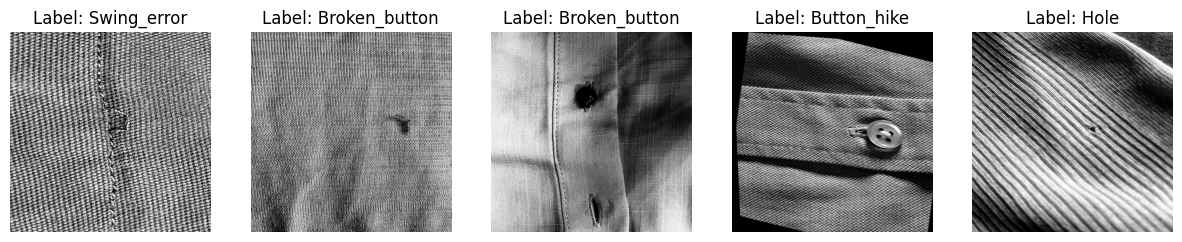

Sample images from testing set:


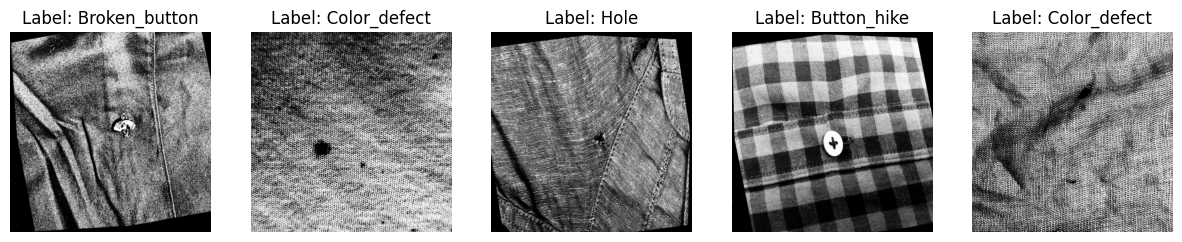

Sample images from Validation set:


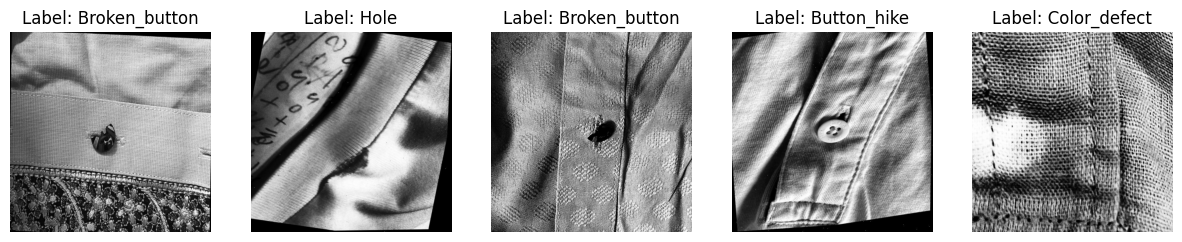

In [13]:
def show_samples(images, labels, label_names, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    for i in range(num_samples):
        axes[i].imshow(images[i])
        label_index = labels[i].argmax()
        label_name = label_names[label_index]
        axes[i].set_title("Label: {}".format(label_name))
        axes[i].axis('off')

    plt.show()

label_names = ['Broken_button','Button_hike','Color_defect','Foreign_yarn','Hole','Swing_error']

print("Sample images from training set:")
show_samples(X_train, y_train, label_names)

print("Sample images from testing set:")
show_samples(X_test, y_test, label_names)
print("Sample images from Validation set:")
show_samples(X_val, y_val, label_names)

# Creating Model

In [14]:
from tensorflow.keras.applications import Xception
xception = Xception(weights='imagenet', include_top=False, input_shape=(640, 640, 3))
for layer in xception.layers:
  layer.trainable = False


83683744/83683744 [==============================] - 3s 0us/step


In [16]:
from tensorflow.keras import Sequential
from keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Flatten, Dense

model = Sequential()
model.add(xception)

model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(rate=0.5))

model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(rate=0.2))

model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.1))

model.add(Flatten())
model.add(Dense(6, activation="softmax"))


In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 20, 20, 2048)      20861480  
                                                                 
 dense_1 (Dense)             (None, 20, 20, 256)       524544    
                                                                 
 dropout (Dropout)           (None, 20, 20, 256)       0         
                                                                 
 dense_2 (Dense)             (None, 20, 20, 128)       32896     
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 128)       0         
                                                                 
 dense_3 (Dense)             (None, 20, 20, 64)        8256      
                                                                 
 dropout_2 (Dropout)         (None, 20, 20, 64)       

In [18]:
from keras.callbacks import ModelCheckpoint
checkpoint_filepath = 'content/Bestmodels/xception_weights_tf_dim_ordering_tf_kernels_notop_best_model.h5'
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                     monitor='val_accuracy',
                                     save_best_only=True,
                                     mode='max',
                                     verbose=1)

In [19]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=30,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint_callback])

Epoch 1/30
54/54 [==============================] - ETA: 0s - loss: 12.8520 - accuracy: 0.2519
Epoch 1: val_accuracy improved from -inf to 0.22911, saving model to content/Bestmodels/xception_weights_tf_dim_ordering_tf_kernels_notop_best_model.h5


You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


54/54 [==============================] - 112s 2s/step - loss: 12.8520 - accuracy: 0.2519 - val_loss: 2.3945 - val_accuracy: 0.2291
Epoch 2/30
54/54 [==============================] - ETA: 0s - loss: 2.3250 - accuracy: 0.3625
Epoch 2: val_accuracy improved from 0.22911 to 0.35040, saving model to content/Bestmodels/xception_weights_tf_dim_ordering_tf_kernels_notop_best_model.h5
54/54 [==============================] - 75s 1s/step - loss: 2.3250 - accuracy: 0.3625 - val_loss: 2.2290 - val_accuracy: 0.3504
Epoch 3/30
54/54 [==============================] - ETA: 0s - loss: 2.0591 - accuracy: 0.4574
Epoch 3: val_accuracy improved from 0.35040 to 0.39084, saving model to content/Bestmodels/xception_weights_tf_dim_ordering_tf_kernels_notop_best_model.h5
54/54 [==============================] - 80s 1s/step - loss: 2.0591 - accuracy: 0.4574 - val_loss: 2.0954 - val_accuracy: 0.3908
Epoch 4/30
54/54 [==============================] - ETA: 0s - loss: 1.8870 - accuracy: 0.5014
Epoch 4: val_accura

In [21]:
from keras.models import load_model
model = load_model(checkpoint_filepath)

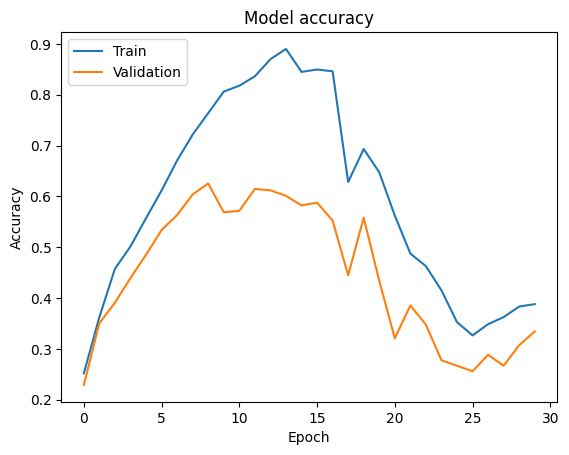

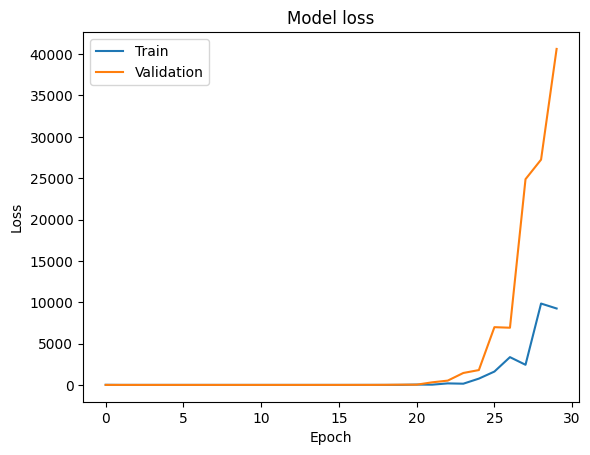

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [23]:
loss,accuracy = model.evaluate(X_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

12/12 [==============================] - 23s 2s/step - loss: 1.6498 - accuracy: 0.6541
loss: 1.649785041809082
Accuracy: 0.6540540456771851


In [24]:
y_pred = model.predict(X_test)

12/12 [==============================] - 13s 1s/step


In [25]:
print(y_test.shape,y_pred.shape)

(370, 6) (370, 6)


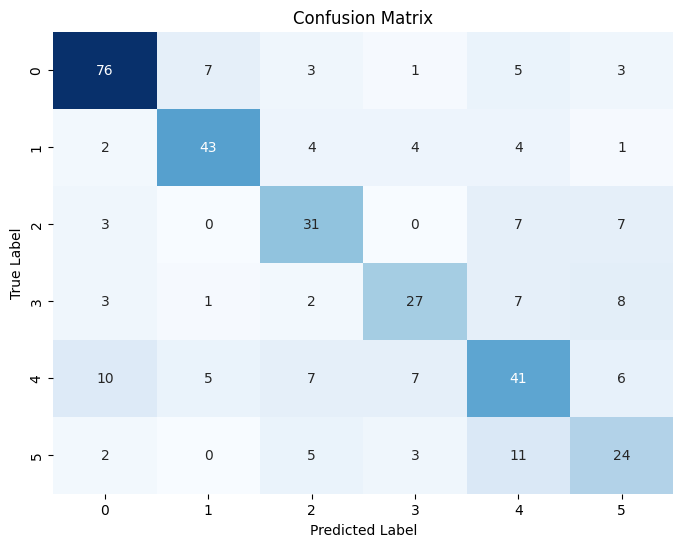

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test_labels, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [27]:
from sklearn.metrics import classification_report

y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

report = classification_report(y_test_labels, y_pred_labels, output_dict=True)

print("Classification Report:")
print(classification_report(y_test_labels, y_pred_labels))

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.80      0.80        95
           1       0.77      0.74      0.75        58
           2       0.60      0.65      0.62        48
           3       0.64      0.56      0.60        48
           4       0.55      0.54      0.54        76
           5       0.49      0.53      0.51        45

    accuracy                           0.65       370
   macro avg       0.64      0.64      0.64       370
weighted avg       0.66      0.65      0.65       370



Sample images with predicted labels:


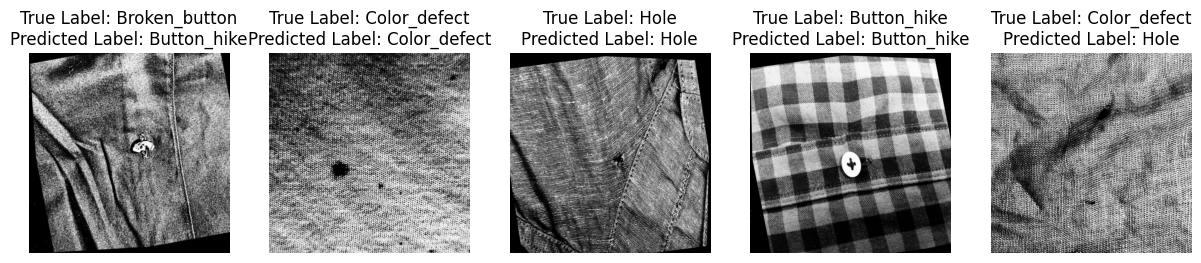

In [28]:
import matplotlib.pyplot as plt

def show_sample_images(images, labels, predicted_labels, label_names, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    for i in range(num_samples):
        axes[i].imshow(images[i])
        true_label = label_names[labels[i]]
        predicted_label = label_names[predicted_labels[i]]
        axes[i].set_title("True Label: {}\nPredicted Label: {}".format(true_label, predicted_label))
        axes[i].axis('off')

    plt.show()

print("Sample images with predicted labels:")
show_sample_images(X_test, y_test_labels, y_pred_labels, label_names)
